In [3]:
!pip install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

In [4]:
import numpy as np
import pandas as pd

import re
from typing import Dict, List, Optional, Text, Tuple
import torchcam
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf


2025-05-13 16:02:25.071369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747152145.252646      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747152145.311078      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# load data

In [5]:
"""Constants for the data reader."""

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

# Data statistics
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, standard deviation)
DATA_STATS = {
    # Elevation in m. 
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    # Pressure
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.53038024902344, 1.7398051, 4.482833),
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.32976, 72.59854),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.94891357421875, 281.08768, 8.982386),
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.09228515625, 295.17383, 9.815496),
    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.024310074806237, 3.8500874, 1.4109988),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),
    # Population density
    # min, 99.9 percentile
    'population': (0., 2534.06298828125, 25.531384, 154.72331),
    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

In [6]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Randomly axis-align crop input and output image tensors.

  Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
    num_in_channels: number of channels in input_img.
    num_out_channels: number of channels in output_img.
  Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
  """
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Center crops input and output image tensors.

  Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
  Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
  """
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img

In [7]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
  """Extracts the base key from the provided key.

  Earth Engine exports TFRecords containing each data variable with its
  corresponding variable name. In the case of time sequences, the name of the
  data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
  where 'variable' is the name of the variable, and n the number of elements
  in the time sequence. Extracting the base key ensures that each step of the
  time sequence goes through the same normalization steps.
  The base key obeys the following naming pattern: '([a-zA-Z]+)'
  For instance, for an input key 'variable_1', this function returns 'variable'.
  For an input key 'variable', this function simply returns 'variable'.

  Args:
    key: Input key.

  Returns:
    The corresponding base key.

  Raises:
    ValueError when `key` does not match the expected pattern.
  """
  match = re.match(r'([a-zA-Z]+)', key)
  if match:
    return match.group(1)
  raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and rescales inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

  Returns:
    Clipped and rescaled input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and normalizes inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

  Returns:
    Clipped and normalized input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  """Creates a features dictionary for TensorFlow IO.

  Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

  Returns:
    A features dictionary for TensorFlow IO.
  """
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Reads a serialized example.

  Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

  Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
  """
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]

  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)
  return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  """Gets the dataset from the file pattern.

  Args:
    file_pattern: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

  Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
  """
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [8]:
BATCH_SIZE = 32
SAMPLE_SIZE = 64

train_dataset = get_dataset('/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_train*',
    data_size=64, sample_size=SAMPLE_SIZE, batch_size=BATCH_SIZE,
    num_in_channels=12, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

validation_dataset = get_dataset('/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_eval*',
    data_size=64, sample_size=SAMPLE_SIZE, batch_size=BATCH_SIZE,
    num_in_channels=12, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

test_dataset = get_dataset('/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_test*',
    data_size=64, sample_size=SAMPLE_SIZE, batch_size=BATCH_SIZE,
    num_in_channels=12, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

I0000 00:00:1747152156.347325      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747152156.347976      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [9]:
for x, y in train_dataset.take(1):
    print(x.shape, y.shape)

for x, y in validation_dataset.take(1):
    print(x.shape, y.shape)

(32, 64, 64, 12) (32, 64, 64, 1)
(32, 64, 64, 12) (32, 64, 64, 1)


# convert to torch ( i dont know how to tensor flow)

In [10]:
import tensorflow as tf
import torch
from torch.utils.data import Dataset



class TFToTorchDataset(Dataset):
    def __init__(self, tf_dataset, clean=False):
        self.samples = []
        for x, y in tf_dataset.as_numpy_iterator():
            for i in range(x.shape[0]):
                # Convert x: (32, 32, 12) → (12, 32, 32)
                x_i = tf.transpose(x[i], perm=[2, 0, 1]).numpy()
                # Convert y: (32, 32, 1) → (1, 32, 32)
                y_i = tf.transpose(y[i], perm=[2, 0, 1]).numpy()

                if clean:
                    if (y_i == -1).any():
                        continue  # Skip this sample
                self.samples.append((
                    torch.tensor(x_i, dtype=torch.float32),
                    torch.tensor(y_i, dtype=torch.float32)
                ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


In [11]:
torch_dataset = TFToTorchDataset(train_dataset, clean=True)
train_loader = torch.utils.data.DataLoader(torch_dataset, batch_size=32, shuffle=True)

torch_dataset_val =  TFToTorchDataset(validation_dataset, clean=True)
val_loader = torch.utils.data.DataLoader(torch_dataset_val, batch_size=32, shuffle=True)

In [47]:
torch_dataset_test = TFToTorchDataset(test_dataset, clean=True)
test_loader = torch.utils.data.DataLoader(torch_dataset_test, batch_size=32, shuffle=True)

In [13]:
N = 5
dataiter = iter(train_loader)

image_list = []
label_list = []
#assume batch size equal to 1, otherwise divide N by batch size
for i in range(0, N):
  image, label = next(dataiter)
  image_list.append(image)
  label_list.append(label)

64


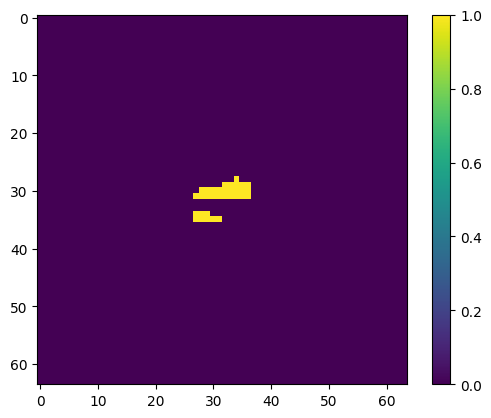

In [14]:
print(len(label_list[0][0][0][0]))
# print(label_list[0][0])
plt.imshow(label_list[4][0][0], cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()


# Helper functions

In [53]:
import matplotlib.pyplot as plt

def show_prediction(model, val_loader):
    model.eval()
    with torch.set_grad_enabled(True):
        x_val, y_val = next(iter(val_loader))
        x_val, y_val = x_val.to(device), y_val.to(device)
        y_val = (y_val == 1).float()

        pred = model(x_val)
        pred_bin = (pred > 0.5).float()

        # Show first sample
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(x_val[0, 11].cpu(), cmap='gray')
        axs[0].set_title("Previous Fire Mask")
        axs[1].imshow(y_val[0, 0].cpu(), cmap='gray')
        axs[1].set_title("Ground Truth")
        axs[2].imshow(pred_bin[0, 0].cpu(), cmap='gray')
        axs[2].set_title("Prediction")
        for ax in axs:
            ax.axis('off')
        plt.show()


In [16]:
def compute_iou(pred, target, threshold=0.5, eps=1e-6):
    pred_bin = (pred > threshold).float()
    target_bin = (target > 0.5).float()

    intersection = (pred_bin * target_bin).sum(dim=(1, 2, 3))
    union = (pred_bin + target_bin - pred_bin * target_bin).sum(dim=(1, 2, 3))
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()

def compute_accuracy(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    correct = (pred_bin == target).float()
    return correct.mean().item()


In [29]:
def evaluate(model, dataloader, threshold=0.5):
    model.eval()
    correct, total = 0, 0
    intersection, union = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = torch.sigmoid(model(X)) > threshold
            correct += (pred == y).sum().item()
            total += torch.numel(y)
            intersection += (pred & (y > 0.5)).sum().item()
            union += ((pred | (y > 0.5))).sum().item()
    acc = correct / total
    iou = intersection / union if union else 0
    print(f"Pixel Accuracy: {acc:.4f}, IoU: {iou:.4f}")

In [25]:
# params = {
#     "lr": 10 ** random.uniform(-5, -3)
# }
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = UNet().to(device)
# train_fcn_model(params)
# show_prediction(model, val_loader)

In [59]:
from matplotlib.colors import ListedColormap

def show_best_and_worst_predictions(model, val_loader, num_examples=2, device='cuda', feature_names=None):
    model.eval()
    ious = []
    examples = []

    with torch.set_grad_enabled(True):
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            y_val = (y_val == 1).float()

            pred = model(x_val)
            pred_bin = (pred > 0.5).float()

            for i in range(x_val.size(0)):
                iou = compute_iou(torch.sigmoid(pred[i].unsqueeze(0)), y_val[i].unsqueeze(0))

                ious.append(iou)
                examples.append({
                    "input": x_val[i].detach().cpu(),
                    "gt": y_val[i].detach().cpu(),
                    "pred": pred_bin[i].detach().cpu(),
                    "iou": iou
                })

    # Sort by IoU
    sorted_examples = sorted(examples, key=lambda ex: ex["iou"])
    worst_examples = sorted_examples[1:1+2*num_examples:2]
    best_examples = sorted_examples[-2*num_examples::2]

    def plot_examples_grid(examples, feature_names=None, normalize_input=True, title="Examples"):
        fire_cmap = ListedColormap([
            '#000000',  # -1 → black
            '#808080',  #  0 → gray
            '#ff7f0e',  #  1 → orange 
        ])

        num_examples = len(examples)
        num_feats = examples[0]["input"].shape[0]
        total_panels = num_feats + 2  # inputs + GT + prediction
    
        fig, axs = plt.subplots(num_examples, total_panels, figsize=(2.2 * total_panels, 2.5 * num_examples),
                                gridspec_kw=dict(wspace=0.05, hspace=0.1))
    
        if num_examples == 1:
            axs = axs[None, :]  # ensure 2D indexing even with one example
    
        for row_idx, ex in enumerate(examples):
            inp = ex["input"]
            gt = ex["gt"][0]
            pred = ex["pred"][0]
            iou = ex["iou"]
    
            for col_idx in range(total_panels):
                ax = axs[row_idx, col_idx]
                if col_idx < num_feats:
                    img = inp[col_idx]
                    if normalize_input:
                        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
                    if col_idx == num_feats - 1:  # PrevFireMask
                        ax.imshow(img, cmap=fire_cmap, vmin=-1, vmax=1)
                    else:
                        ax.imshow(img, cmap='viridis')

                elif col_idx == num_feats:
                    ax.imshow(gt, cmap=fire_cmap, vmin=-1, vmax=1)
                elif col_idx == num_feats + 1:
                    ax.imshow(pred, cmap=fire_cmap, vmin=-1, vmax=1)

                    ax.set_title(f"IoU: {iou:.2f}", fontsize=10)
    
                if row_idx == 0:
                    # Top row: show feature titles
                    if col_idx < num_feats:
                        label = feature_names[col_idx] if feature_names else f"Input {col_idx}"
                    elif col_idx == num_feats:
                        label = "Ground Truth"
                    else:
                        label = "Prediction"
                    ax.set_title(label, fontsize=12)
    
                ax.axis("off")

        fig.suptitle(title, fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        plt.savefig(f"{title}_jpg", dpi=300, bbox_inches='tight')
        
        plt.show()


    plot_examples_grid(worst_examples, title="Worst Examples", feature_names = feature_names)

    plot_examples_grid(best_examples, title="Best Examples", feature_names = feature_names)

# Training loop

In [17]:
def save_checkpoint(model, optimizer, epoch, loss, filename="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filename)

In [18]:
class EarlyStopping:
    #GeeksforGeeks
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score <= self.best_score + self.delta:
            self.counter += 1
            print("counter set to ", self.counter)
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [20]:

def train_model(model, train_dataset, val_dataset, params, device):
    """
    A reusable training loop that dynamically creates components based on hyperparameter tuning parameters.

    Args:
        model (torch.nn.Module): The model to train (e.g., U-Net or Vision Transformer).
        train_dataset (Dataset): The training dataset.
        val_dataset (Dataset): The validation dataset.
        params (dict): Dictionary containing hyperparameters (e.g., learning rate, batch size, optimizer type).
        device (torch.device): Device to train on (e.g., 'cuda' or 'cpu').
        num_epochs (int): Number of epochs to train for.

    Returns:
        dict: A dictionary containing training and validation losses, IoU, and accuracy for each epoch.
    """
    # === Create DataLoaders ===
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=params["batch_size"], shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=params["batch_size"], shuffle=False
    )
    

    # === Define Optimizer ===
    if params["optimizer"] == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
    elif params["optimizer"] == "adamw":
        optimizer = torch.optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
    elif params["optimizer"] == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"], momentum=0.9)
    else:
        raise ValueError(f"Unsupported optimizer: {params['optimizer']}")

    num_epochs = params.get("num_epochs", 10)

    # === Define Loss Function ===
    pos_weight = params.get("pos_weight", 0.85 / 0.15) # Default to 1.0 if not provided

    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))

    # === Training Loop ===
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_iou": [],
        "val_acc": []
    }
    early_stopping = EarlyStopping(patience=5, delta=0.01)

    for epoch in range(num_epochs):
        # === Training ===
        model.train()
        train_loss = 0.0

        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x_batch.size(0)

        train_loss /= len(train_loader.dataset)
        history["train_loss"].append(train_loss)

        # === Validation ===
        model.eval()
        val_loss = 0.0
        total_iou = 0.0
        total_acc = 0.0
        n_samples = 0

        if epoch % 5 == 0:
            filename = f"checkpoint_epoch_{epoch+1}.pth"
            save_checkpoint(model, optimizer, epoch, loss, filename)

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)

                # Forward pass
                outputs = model(x_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item() * x_val.size(0)

                # Metrics
                batch_iou = compute_iou(torch.sigmoid(outputs), y_val)
                batch_acc = compute_accuracy(torch.sigmoid(outputs), y_val)

                total_iou += batch_iou * x_val.size(0)
                total_acc += batch_acc * x_val.size(0)
                n_samples += x_val.size(0)

        val_loss /= len(val_loader.dataset)
        mean_iou = total_iou / n_samples
        mean_acc = total_acc / n_samples

        history["val_loss"].append(val_loss)
        history["val_iou"].append(mean_iou)
        history["val_acc"].append(mean_acc)

        # Print epoch summary
        print(f"Epoch {epoch + 1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"IoU: {mean_iou:.4f} | Acc: {mean_acc:.4f}")
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return history

# FCN

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, dropout_rate=0.3, in_channels=12, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c, dropout_rate):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(inplace=True),
                nn.Dropout2d(dropout_rate)
            )

        self.encoder1 = conv_block(in_channels, 64, dropout_rate)
        self.encoder2 = conv_block(64, 128, dropout_rate)
        self.encoder3 = conv_block(128, 256, dropout_rate)
        self.encoder4 = conv_block(256, 256, dropout_rate)
        
        self.pool = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            # conv_block(128, 256, dropout_rate),
            conv_block(256, 512, dropout_rate),
            conv_block(512, 512, dropout_rate)
        )

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256, 0)
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128, 0)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64, 0)

        self.output_layer = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, kernel_size=1)
        )


    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e3))

        # Decoder
        d3 = self.up3(b)#+ e3 
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.decoder3(d3)

        d2 = self.up2(d3)#+ 
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.decoder2(d2)

        d1 = self.up1(d2)#+ e1
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.decoder1(d1)

        pred_map = self.output_layer(d1)
        
        return pred_map

# Hyperparameter tuning

In [22]:
import random
from itertools import count
import gc

def random_search(model_type, device, n_trials=12):
    best_val_loss = float('inf')
    best_params = None

    for trial in range(n_trials):
        print("trial number ", trial+1)
        if model_type == "unet":
            params = {
                "lr": 10 ** random.uniform(-5, -3),
                "batch_size": random.choice([16, 32, 64]),
                "optimizer": random.choice(["adam", "adamw", "sgd"]),
                "weight_decay": random.choice([0, 1e-4, 1e-3]),
                "dropout_rate": random.uniform(0, 0.5),
                "num_epochs": 10,
            }
            print(params)
            model = UNet(dropout_rate = params["dropout_rate"]).to(device)
        history = train_model(model, torch_dataset, torch_dataset_val, params, device)

        val_loss = history["val_loss"][-1]
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params
        gc.collect()
        torch.cuda.empty_cache()

    return best_params

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
best_params_unet = random_search(model_type = "unet", device = device)
print(best_params_unet)

cuda
trial number  1
{'lr': 0.00040188025079528457, 'batch_size': 64, 'optimizer': 'sgd', 'weight_decay': 0.001, 'dropout_rate': 0.31946242215179077, 'num_epochs': 10}
Epoch 1/10 | Train Loss: 0.4016 | Val Loss: 0.3030 | IoU: 0.0649 | Acc: 0.9846
Epoch 2/10 | Train Loss: 0.2387 | Val Loss: 0.2757 | IoU: 0.0649 | Acc: 0.9846
Epoch 3/10 | Train Loss: 0.2250 | Val Loss: 0.2713 | IoU: 0.0649 | Acc: 0.9846
counter set to  1
Epoch 4/10 | Train Loss: 0.2149 | Val Loss: 0.2645 | IoU: 0.0649 | Acc: 0.9846
Epoch 5/10 | Train Loss: 0.2036 | Val Loss: 0.2648 | IoU: 0.0649 | Acc: 0.9846
counter set to  1
Epoch 6/10 | Train Loss: 0.1924 | Val Loss: 0.2604 | IoU: 0.0649 | Acc: 0.9846
counter set to  2
Epoch 7/10 | Train Loss: 0.1800 | Val Loss: 0.2533 | IoU: 0.1043 | Acc: 0.9820
Epoch 8/10 | Train Loss: 0.1705 | Val Loss: 0.2522 | IoU: 0.1415 | Acc: 0.9796
counter set to  1
Epoch 9/10 | Train Loss: 0.1633 | Val Loss: 0.2481 | IoU: 0.1530 | Acc: 0.9773
counter set to  2
Epoch 10/10 | Train Loss: 0.157

In [ ]:
# Next steps:
# 1. Run hyperparameter tuning on 8 epochs for 8 trials +
# 2. Train both models for 20 epochs with early stopping + 
# 3. Visualize attention maps
# 4. Visualize activations + 
# 5. Identify misclassified samples 
# 6. Test performance with merging the "uncertainty" class into fire/no-fire

# _____NOTES___________
# skip connections invrease losses,sccuracy but not IoU
# make sure to change forward when removing skip connctions
# don't go over 512



In [27]:
best_params_unet = {'lr': 0.0004743102816657763, 
                    'batch_size': 64, 
                    'optimizer': 'adamw', 
                    'weight_decay': 0, 
                    'dropout_rate': 0.19050225456894704, 
                    'num_epochs': 50}

In [28]:
# train with tuned parameters
unet = UNet().to(device)
# manual_params = {'lr': 4.511683720714809e-05, 
#                   'batch_size': 64, 
#                   'optimizer': 'adamw', 
#                   'weight_decay': 0.001, 
#                   'num_epochs': 5}
best_params_unet['num_epochs'] = 50
print(best_params_unet)
unet_history = train_model(unet, torch_dataset, torch_dataset_val, best_params_unet, device)
unet.eval()


{'lr': 0.0004743102816657763, 'batch_size': 64, 'optimizer': 'adamw', 'weight_decay': 0, 'dropout_rate': 0.19050225456894704, 'num_epochs': 50}
Epoch 1/50 | Train Loss: 0.1666 | Val Loss: 0.2108 | IoU: 0.2144 | Acc: 0.9762
Epoch 2/50 | Train Loss: 0.1158 | Val Loss: 0.1998 | IoU: 0.2238 | Acc: 0.9735
Epoch 3/50 | Train Loss: 0.1098 | Val Loss: 0.1892 | IoU: 0.2045 | Acc: 0.9712
Epoch 4/50 | Train Loss: 0.1072 | Val Loss: 0.1766 | IoU: 0.2231 | Acc: 0.9715
Epoch 5/50 | Train Loss: 0.1061 | Val Loss: 0.1841 | IoU: 0.2368 | Acc: 0.9747
counter set to  1
Epoch 6/50 | Train Loss: 0.1040 | Val Loss: 0.1762 | IoU: 0.2396 | Acc: 0.9752
counter set to  2
Epoch 7/50 | Train Loss: 0.1028 | Val Loss: 0.1811 | IoU: 0.2317 | Acc: 0.9731
counter set to  3
Epoch 8/50 | Train Loss: 0.1014 | Val Loss: 0.1879 | IoU: 0.2369 | Acc: 0.9716
counter set to  4
Epoch 9/50 | Train Loss: 0.0994 | Val Loss: 0.1824 | IoU: 0.2414 | Acc: 0.9781
counter set to  5
Early stopping


NameError: name 'evaluate' is not defined

In [30]:
evaluate(unet, test_loader)

Pixel Accuracy: 0.9806, IoU: 0.2492


# Generate Saliency maps

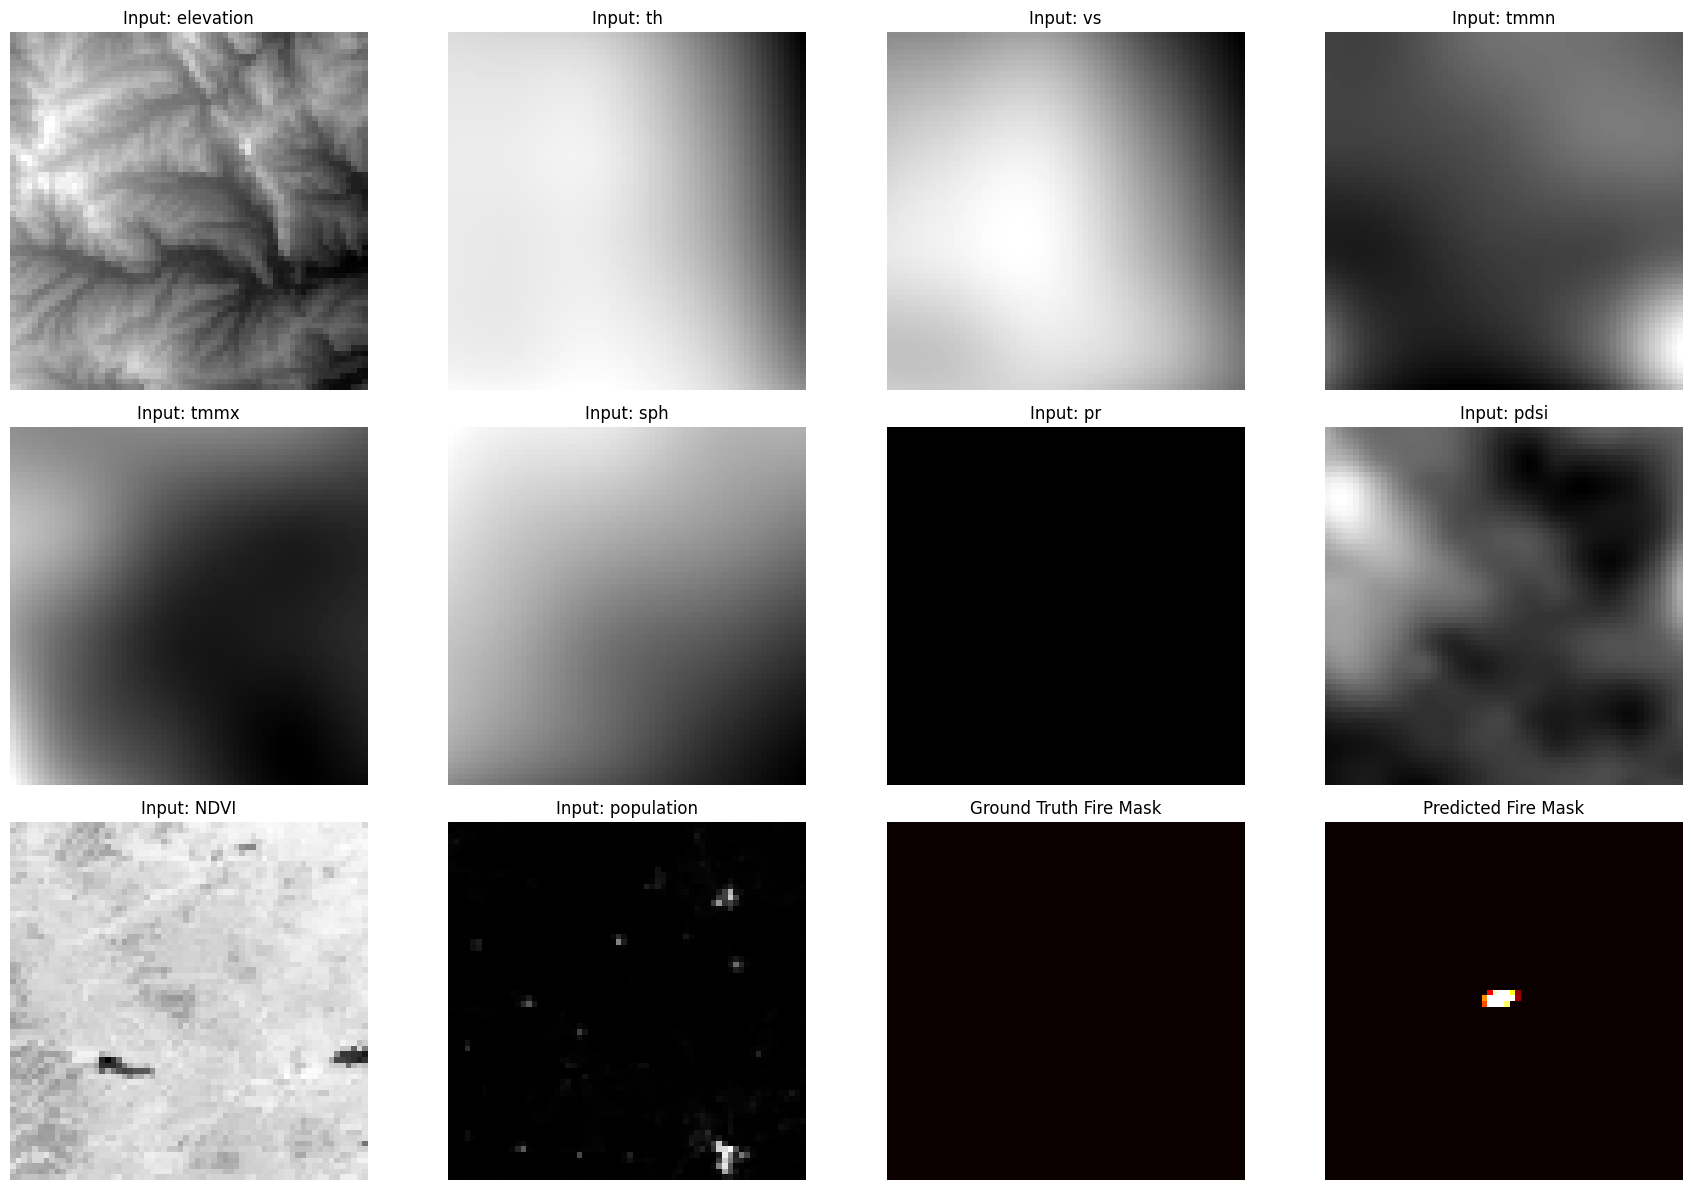

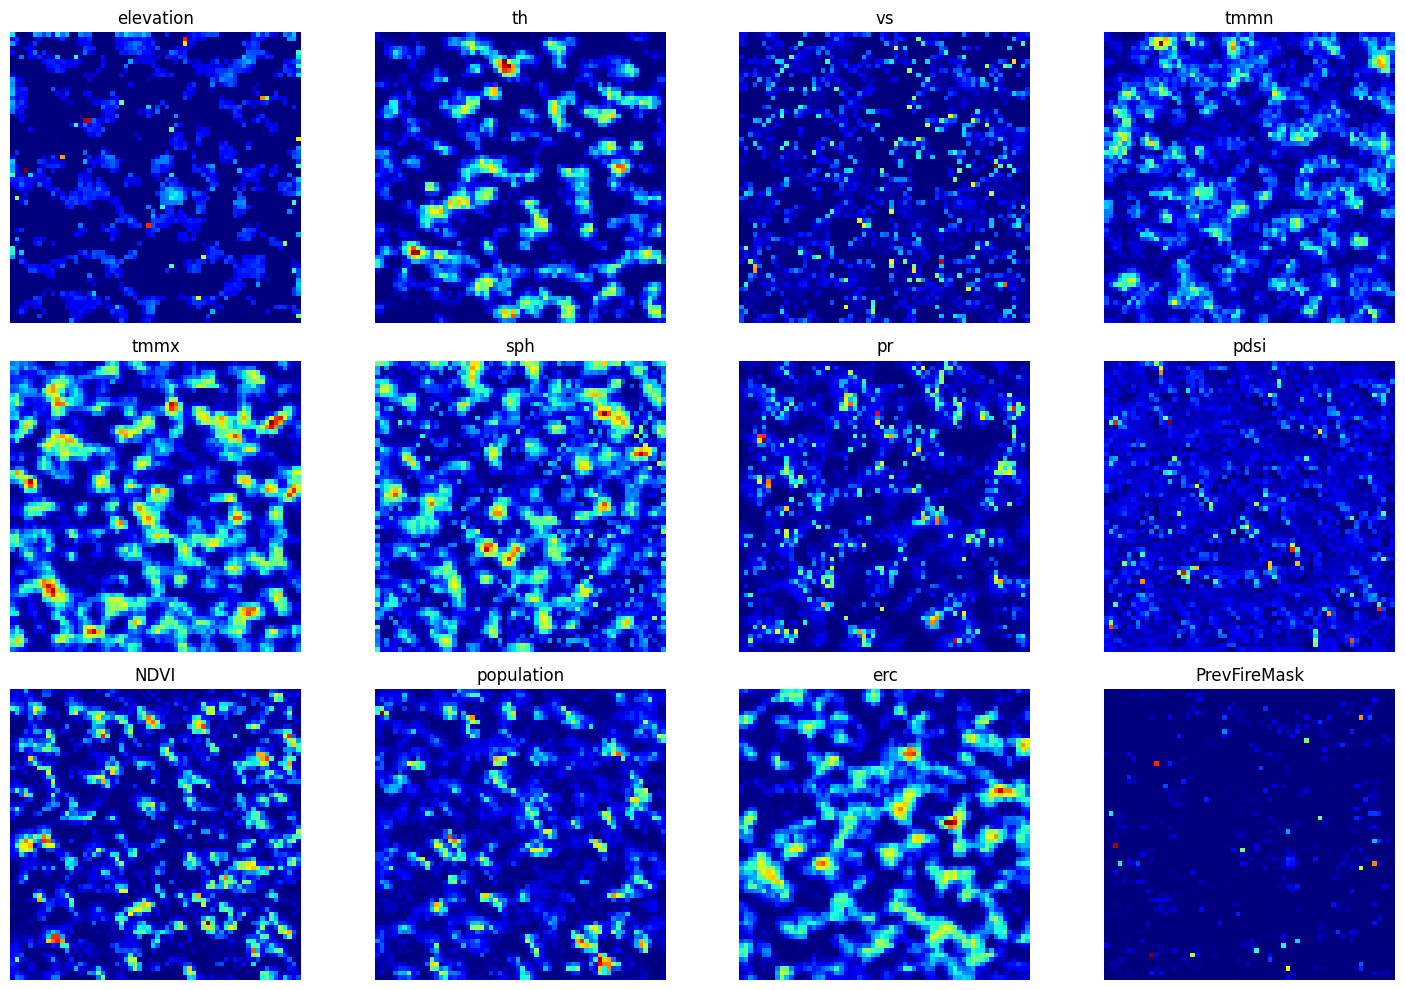

In [44]:
from torchcam.methods import SmoothGradCAMpp

target_layer = 'encoder1' 
cam_extractor = SmoothGradCAMpp(unet, target_layer)
feature_names = INPUT_FEATURES  

loader = test_loader

x_val, y_val = next(iter(loader))
x_val, y_val = x_val.to(device), y_val.to(device)

input_sample = x_val[0].unsqueeze(0) 
ground_truth = y_val[0].unsqueeze(0)  
pred_mask = unet(x_val)


saliency_maps = []

for channel_idx in range(input_sample.shape[1]):
    single_channel_input = torch.zeros_like(input_sample)
    single_channel_input[:, channel_idx, :, :] = input_sample[:, channel_idx, :, :]

    output = unet(single_channel_input)

    activation_map = cam_extractor(0, output)
    saliency_maps.append(activation_map[0].cpu().numpy())

plt.figure(figsize=(18, 12))
    
plt.subplot(3, 4, 1)
plt.imshow(input_sample[0, 0].cpu().numpy(), cmap='gray')
plt.title(f"Input: {feature_names[0]}")
plt.axis('off')

for i in range(1, min(12, input_sample.shape[1])):
    plt.subplot(3, 4, i+1)
    plt.imshow(input_sample[0, i].cpu().numpy(), cmap='gray')
    plt.title(f"Input: {feature_names[i]}")
    plt.axis('off')

# Plot ground truth and prediction
plt.subplot(3, 4, 11)
plt.imshow(ground_truth.cpu().numpy().squeeze(), cmap='hot', vmin=0, vmax=1)
plt.title("Ground Truth Fire Mask")
plt.axis('off')

plt.subplot(3, 4, 12)
plt.imshow(pred_mask[0].cpu().detach().numpy().squeeze(), cmap='hot', vmin=0, vmax=1)
plt.title("Predicted Fire Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 4, figsize=(15, 10))
for idx, ax in enumerate(axes.flat):
    if idx < len(feature_names):
        if saliency_maps[idx].ndim > 2:
            saliency_maps[idx] = saliency_maps[idx].squeeze() 
        ax.imshow(saliency_maps[idx], cmap='jet', interpolation='nearest')
        ax.set_title(feature_names[idx])
        ax.axis('off')
plt.tight_layout()

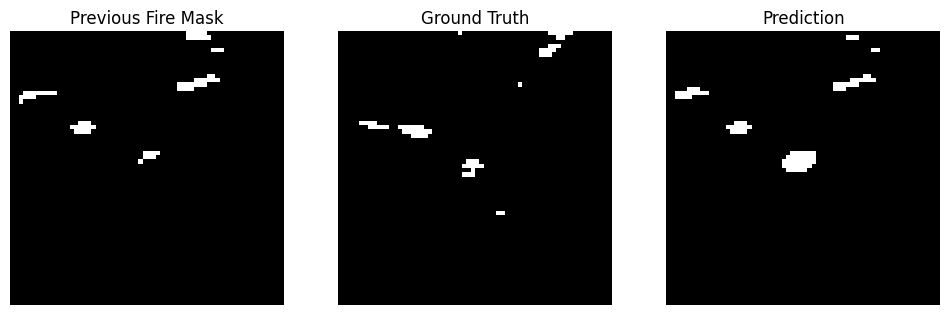

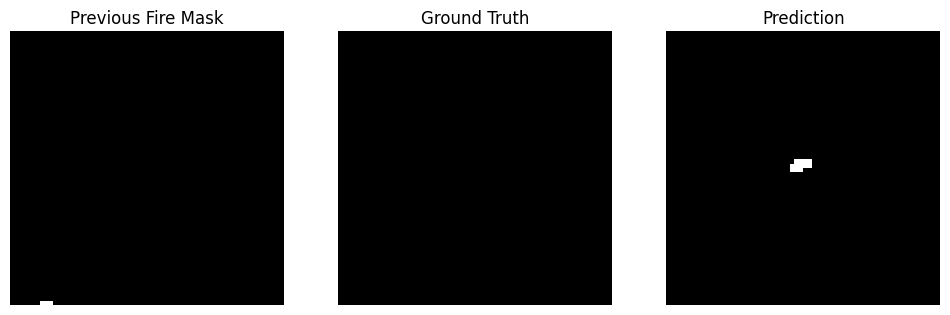

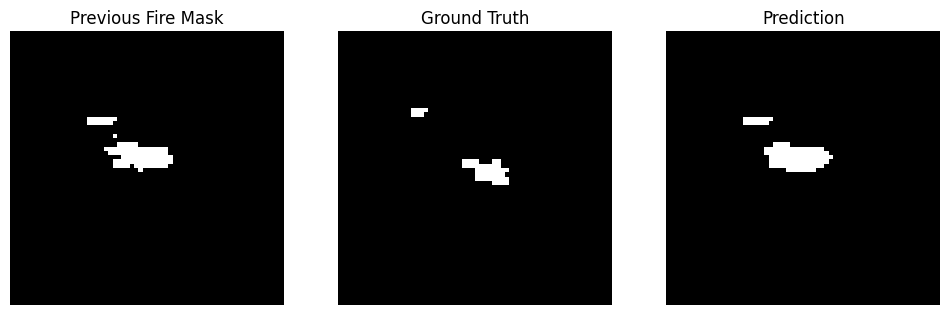

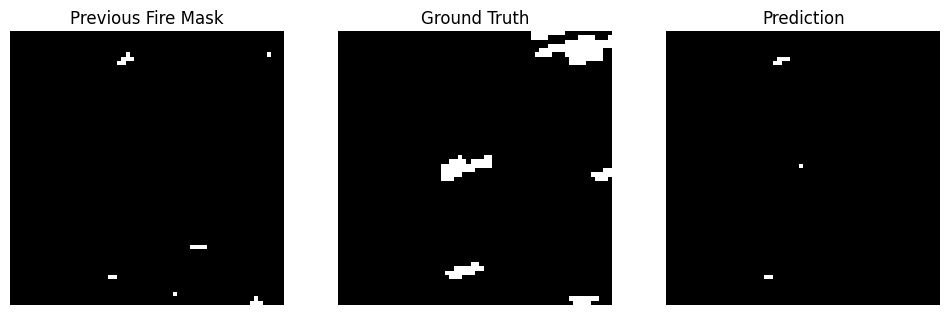

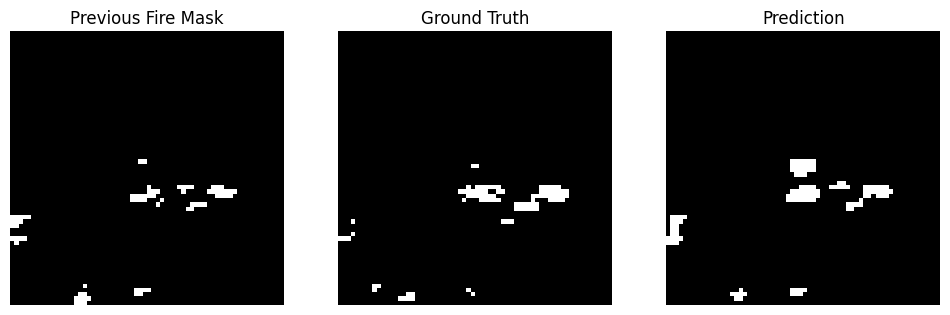

In [55]:
for i in range(5):
    show_prediction(unet, test_loader)

/tmp/ipykernel_31/1287878729.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


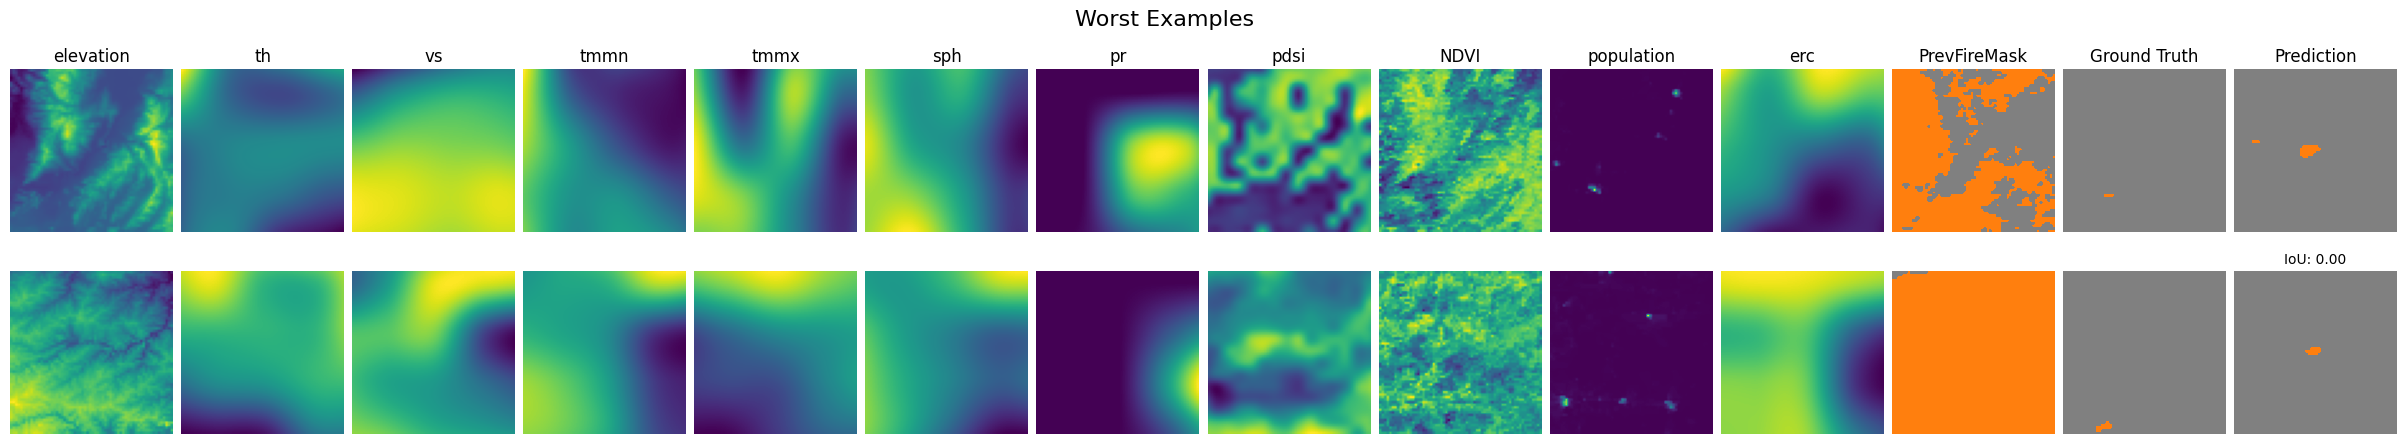

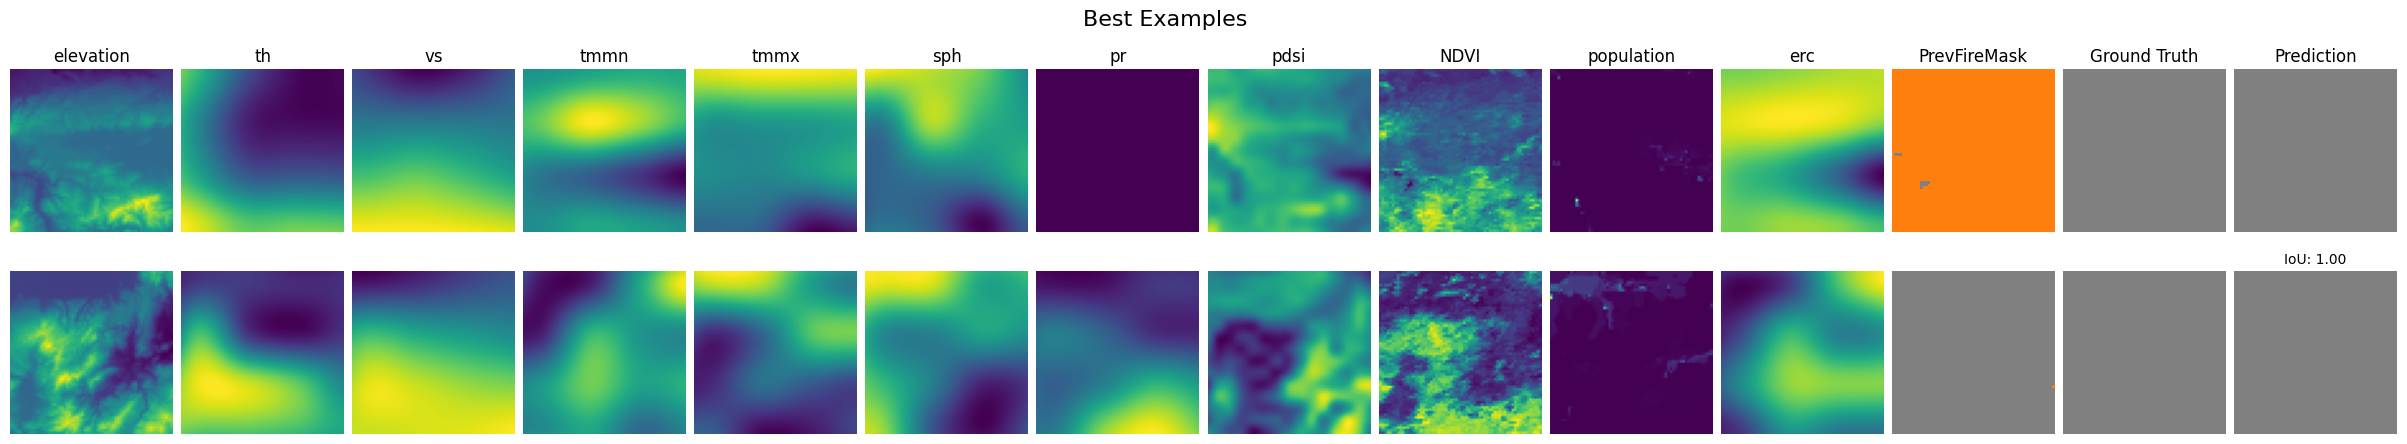

In [60]:
show_best_and_worst_predictions(unet, test_loader, device=device, feature_names=INPUT_FEATURES)